In [5]:
%matplotlib widget
import warnings
import fnmatch
import os
#import ccdproc
from ccdproc import Combiner, combine, subtract_bias, subtract_dark
from astropy.utils.exceptions import AstropyWarning
from time import gmtime, strftime
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy import units as u

from astropy.nddata import CCDData, StdDevUncertainty
from specutils import Spectrum1D
import ccdproc
from astropy.stats import mad_std
from ccdproc import trim_image, Combiner
from astropy.io import fits
from time import gmtime, strftime


In [2]:
warnings.simplefilter('ignore', category=AstropyWarning)

dir = 'e:/Astro/Captures/20231008_Void/'
bias_files = [dir + f for f in fnmatch.filter(os.listdir(dir), 'Bias*')]
dark_files = [dir + f for f in fnmatch.filter(os.listdir(dir), 'dark*')]
flat_files = [dir + f for f in fnmatch.filter(os.listdir(dir), 'flat*')]
sci_files  = [dir + f for f in fnmatch.filter(os.listdir(dir), 'deneb*')]

bias_header = fits.open(bias_files[0])[0].header
dark_header = fits.open(dark_files[0])[0].header
flat_header = fits.open(flat_files[0])[0].header
sci_header = fits.open(sci_files[0])[0].header

print ('bias combine...')
from datetime import datetime; print(datetime.now())
bias_list = [CCDData.read(f, unit = u.adu) for f in bias_files]
bias_master = ccdproc.combine(bias_list, method='median', mem_limit = 1e9)
bias_master = CCDData(bias_master.data.astype('float32'), unit = u.adu, header = bias_master.header)
bias_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
bias_master.meta['combined'] = True
bias_master.meta['history'] = 'combined from {} bias file(s)'.format(len(bias_files))
bias_master.write(dir + 'masterbias.fit', overwrite=True)
print('\n\nbias master created : \n', repr(bias_master.header))
bias_list = None

darks_list = []
for dark_file in dark_files:
    print ('bias sub to dark {} ...'.format(dark_file))
    from datetime import datetime; print(datetime.now())
    dark_data = CCDData.read(dark_file, unit = u.adu)
    dark_sub = ccdproc.subtract_bias(dark_data, bias_master)
    dark_sub = CCDData(dark_sub.data.astype('float32'), unit = u.adu, header = dark_data.header)
    dark_data = None
    darks_list.append(dark_sub)

print ('dark combine...')
from datetime import datetime; print(datetime.now())
dark_master = ccdproc.combine(darks_list, method='median', mem_limit = 1e9)
dark_master = CCDData(dark_master.data.astype('float32'), unit = u.adu, header = dark_master.header)
dark_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
dark_master.meta['combined'] = True
dark_master.meta['history'] = 'bias substracted + combined from {} dark file(s)'.format(len(dark_files))
dark_master.write(dir + 'masterdark.fit', overwrite=True)
print('\n\dark master created : \n', repr(dark_master.header))
darks_list = None

flats_list = []
for flat_file in flat_files:
    print ('bias sub to flat {} ...'.format(flat_file))
    from datetime import datetime; print(datetime.now())
    flat_data = CCDData.read(flat_file, unit = u.adu)
    flat_sub = ccdproc.subtract_bias(flat_data, bias_master)
    flat_sub = CCDData(flat_sub.data.astype('float32'), unit = u.adu, header = flat_data.header)
    flat_data = None
    flats_list.append(flat_sub)

print ('flat combine...')
from datetime import datetime; print(datetime.now())
flat_master = ccdproc.combine(flats_list, method='median', mem_limit = 1e9)
flat_master = CCDData(flat_master.data.astype('float32'), unit = u.adu, header = flat_master.header)
flat_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
flat_master.meta['combined'] = True
flat_master.meta['history'] = 'bias substracted + combined from {} flat file(s)'.format(len(flat_files))
flat_master.write(dir + 'masterflat.fit', overwrite=True)
print('\n\flat master created : \n', repr(flat_master.header))
flats_list = None

sci_list = []
for sci_file in sci_files:
    print ('bias sub to science {} ...'.format(sci_file))
    from datetime import datetime; print(datetime.now())
    sci_data = CCDData.read(sci_file, unit = u.adu)
    sci_sub_bias = ccdproc.subtract_bias(sci_data, bias_master)
    sci_data = None;
    print ('dark sub to science {} ...'.format(sci_file))
    from datetime import datetime; print(datetime.now())
    sci_sub_dark = ccdproc.subtract_dark(sci_sub_bias, dark_master, exposure_unit=u.second, scale = True, dark_exposure = 300.0*u.second, data_exposure = 200.0*u.second)   
    sci_sub_bias = None;
    print ('flat divide science {} ...'.format(sci_file))
    from datetime import datetime; print(datetime.now())
    sci_sub_dark = ccdproc.flat_correct(sci_sub_dark, flat_master)   
    sci_sub = CCDData(sci_sub_dark.data.astype('float32'), unit = u.adu, header = sci_sub_dark.header)
    sci_sub_dark = None;   
    sci_list.append(sci_sub)

print ('science combine...')
from datetime import datetime; print(datetime.now())
sci_master = ccdproc.combine(sci_list, method='sum', mem_limit = 1e9)
sci_master = CCDData(sci_master.data.astype('float32'), unit = u.adu, header = sci_master.header)
sci_master.meta['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
sci_master.meta['combined'] = True
sci_master.meta['history'] = 'bias substracted + dark substrated + combined from {} sciences file(s)'.format(len(sci_files))
sci_master.write(dir + 'mastersci.fit', overwrite=True)
sci_list = None

"""
darkhdr = darklist[0].header 
inexp = float(inhdr['EXPTIME'])
darkexp = float(darkhdr['EXPTIME'])
darkscale = inexp/darkexp
outimage = (inimage -inbias) - darkscale * (indark -inbias)
"""

bias_list = None
darks_list = None
flats_list = None
sci_list = None

bias_master = None
dark_master = None
flat_master = None
sci_master = None

bias_header = None
flat_header = None
dark_header = None
sci_header = None


bias combine...
2024-02-13 18:21:38.869302
INFO: splitting each image into 21 chunks to limit memory usage to 1000000000.0 bytes. [ccdproc.combiner]


KeyboardInterrupt: 

In [ ]:
bias_list = None
darks_list = None
flats_list = None
sci_list = None

bias_master = None
dark_master = None
flat_master = None
sci_master = None

bias_header = None
flat_header = None
dark_header = None
sci_header = None

In [ ]:
from astropy.io import fits
from time import gmtime, strftime

def fits_combine(images_list: list[str], operation, outfile: str) -> np:
    images = [fits.open(f)[0].data for f in images_list]
    headers = [fits.open(f)[0].header for f in images_list]
    new_image = operation(images, axis=0)
    out_file = fits.PrimaryHDU(new_image.astype(np.float32), headers[0])
    out_hdr = out_file.header
    out_hdr['DATE'] = strftime("%Y-%m-%dT%H:%M:%S", gmtime())
    out_hdr['history'] = '{} of {} images'.format(str(operation), len(images_list))
    out_file.writeto(outfile, overwrite = True)
    images = None
    return (new_image)

def combine_fits(files_data: list[np], operation, outfile: str) -> None:
    img_array = []
    hdu_array = []
    nb_images = 0
   
    median_array = operation(img_array, axis=0)
    out_file = fits.PrimaryHDU(median_array, hdu_array[0])
    out_hdr = out_file.header
    out_hdr['DATE'] = strftime("%Y-%m-%d %H:%M:%S", gmtime())
    out_hdr['history'] = 'Median of %d images by numpy.median' %(nb_images,)
    out_hdr['history'] = 'First image '+  files[0]
    out_hdr['history'] = 'Last image  '+  files[nb_images - 1]
    out_file.writeto(outfile, overwrite = True)


In [7]:
dir = 'e:/Astro/Captures/20231008_Void/'
sci_data = CCDData.read(dir + 'deneb-200s-1.fit', unit = u.adu)
master_bias = CCDData.read(dir + 'masterbias.fit', unit = u.adu)
master_dark = CCDData.read(dir + 'masterdark.fit', unit = u.adu)
master_flat = CCDData.read(dir + 'masterflat.fit', unit = u.adu)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [8]:
#sci_data.header['EXPOSURE'] = sci_data.header['EXPTIME']  # for dark subtraction

nccd = ccdproc.ccd_process(sci_data, oscan=None, gain_corrected=False,
                           trim=None,
                           gain=2.0*u.electron/u.adu,
                           readnoise=5*u.electron,
                           dark_frame=master_dark,
                           master_bias = master_bias,
                           exposure_key='EXPTIME',
                           exposure_unit=u.second,
                           dark_scale=True,
                           master_flat=master_flat)


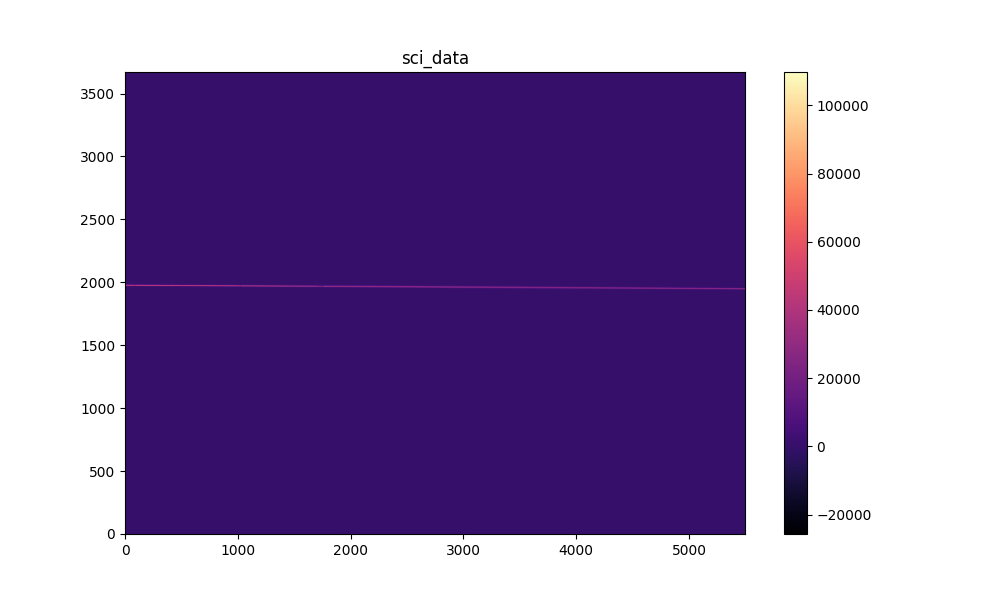

In [9]:
plt.figure(figsize=(10,6))
plt.imshow(nccd, origin='lower', aspect='auto', cmap=plt.cm.magma)
plt.title('sci_data')
#plt.clim(np.percentile(sci_data, (10, 90)))
cb = plt.colorbar()

In [ ]:
#newccd = ccdproc.cosmicray_median(nccd, thresh=5, mbox=11, rbox=11, gbox=5) 
#cr_cleaned = ccdproc.cosmicray_lacosmic(nccd, sigclip=1)
cr_cleaned = ccdproc.cosmicray_median(nccd, mbox=11, rbox=11, gbox=5, error_image = np.ones(nccd.shape))


In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(cr_cleaned, origin='lower', aspect='auto', cmap=plt.cm.grey)
plt.title('sci_data')
#plt.clim(np.percentile(sci_data, (10, 90)))
cb = plt.colorbar()

In [83]:
from specreduce import tracing, background, extract
sci_tr = tracing.FitTrace(nccd,  peak_method='max')   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
bg = background.Background.two_sided(nccd, sci_tr, separation=50, width=50) 
extract = extract.BoxcarExtract(nccd - bg, sci_tr, width = 5)
sci_spectrum = extract()


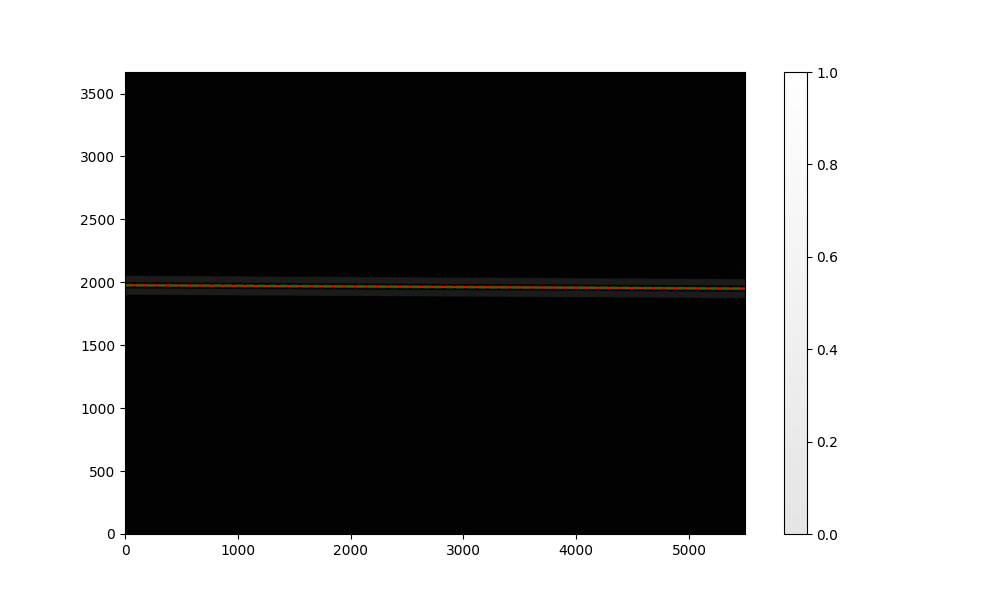

In [11]:
plt.figure(figsize=(10,6))
plt.imshow(sci_data, origin='lower', aspect='auto', cmap=plt.cm.gray)
plt.imshow(bg.bkg_wimage, origin='lower', aspect='auto', cmap=plt.cm.gray, alpha=0.1)
plt.plot(sci_tr.trace , color='r')
plt.plot(sci_tr.trace+extract.width , color='g', linestyle='dashed', alpha=0.5)
plt.plot(sci_tr.trace-extract.width , color='g', linestyle='dashed', alpha=0.5)

cb = plt.colorbar()



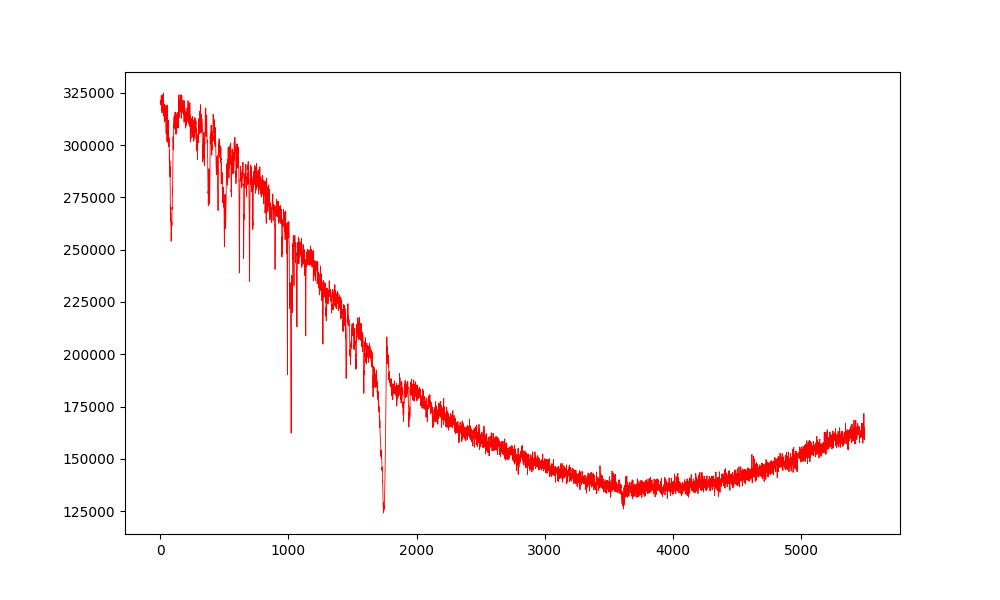

In [84]:
plt.figure(figsize=(10,6))
plt.plot(sci_spectrum.flux, color='r',  linewidth = '0.6')


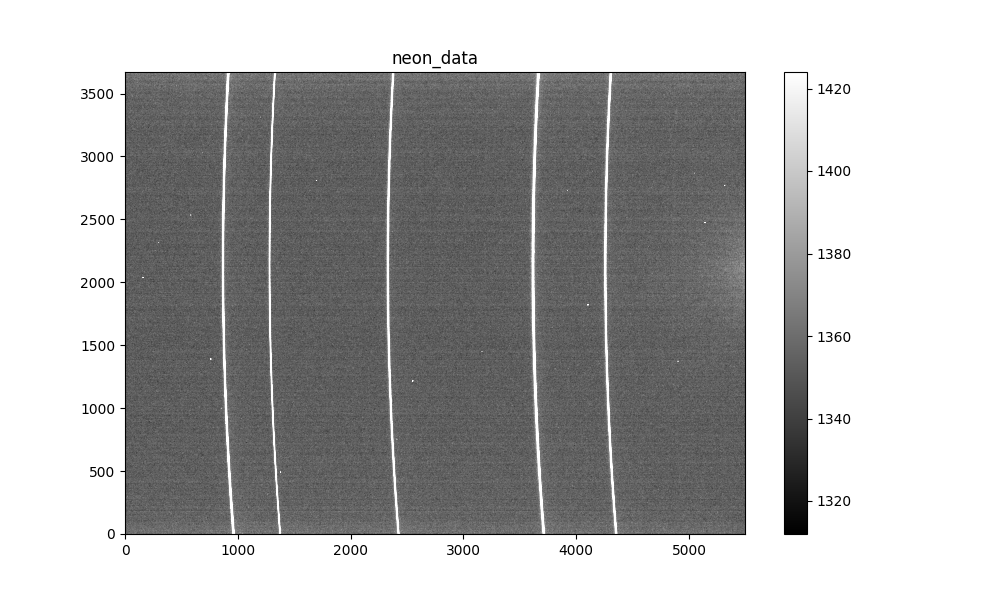

In [26]:
dir = 'e:/Astro/Captures/20231008_Void/'
neon_data = CCDData.read(dir + 'neon-15s-2.fit', unit = u.adu)
plt.figure(figsize=(10,6))
plt.imshow(neon_data, origin='lower', aspect='auto', cmap=plt.cm.grey)
plt.title('neon_data')
plt.clim(np.percentile(sci_data, (10, 90)))
cb = plt.colorbar()

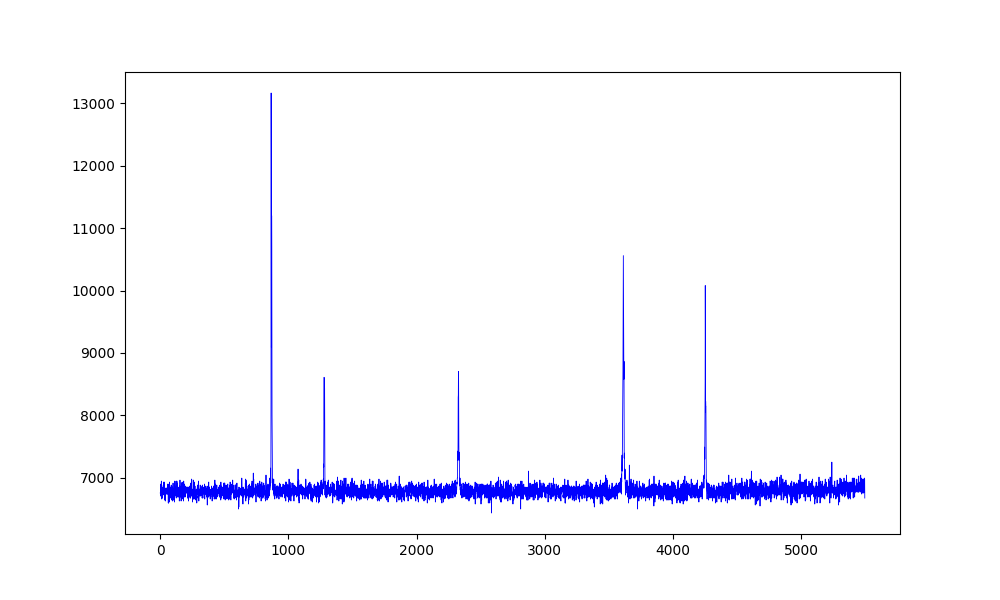

In [85]:
from specreduce import tracing, background, extract
#specreduce.tracing.ArrayTrace(image: NDData, trace: ndarray)
neon_tr = tracing.ArrayTrace(neon_data, [1900, 2000])   #FitTrace(image, peak_method='gaussian', guess=trace_pos)
#bg = background.Background.two_sided(nccd, sci_tr, separation=50, width=50) 
extract = extract.BoxcarExtract(neon_data , neon_tr, width = 5)
neon_spectrum = extract()
plt.figure(figsize=(10,6))
plt.plot(neon_spectrum.flux, color='b',  linewidth = '0.6')



[-0.6745298   0.43377463  0.55365824 -0.11024465 -0.20265843] Angstrom
Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           slope            intercept    
       Angstrom / pix        Angstrom    
    ------------------- -----------------
    0.06186690092200992 6453.504059796365


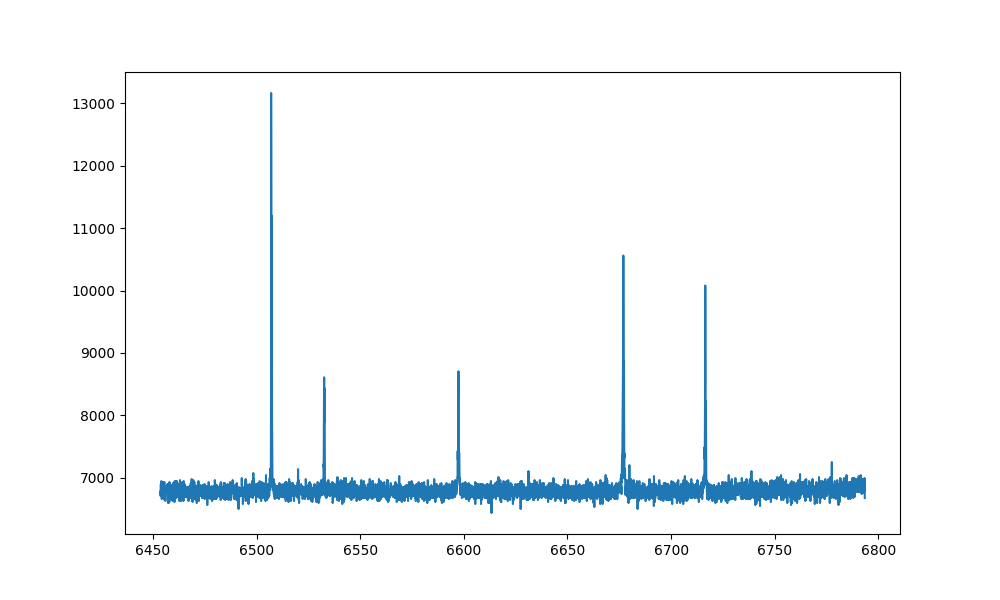

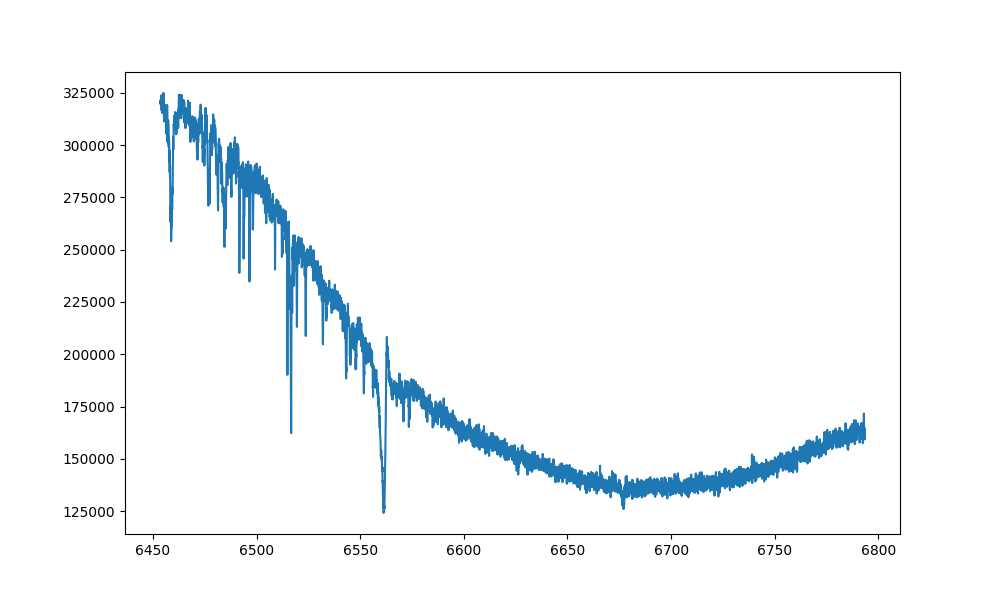

In [89]:
import astropy.units as u
from specreduce import WavelengthCalibration1D
from astropy.table import QTable

pixels = [868, 1276, 2342, 3635, 4263]*u.pix
wavelength = [6506.53, 6532.88, 6598.95, 6678.28, 6717.04]*u.AA
line_list = QTable([pixels, wavelength], names=["pixel_center", "wavelength"])
test_cal = WavelengthCalibration1D(neon_spectrum, matched_line_list=line_list)
print(test_cal.residuals )
print(test_cal.fitted_model )
neon_calibrated_spectrum = test_cal.apply_to_spectrum(neon_spectrum)
sci_calibrated_spectrum = test_cal.apply_to_spectrum(sci_spectrum)

plt.figure(figsize=(10,6))
plt.plot(neon_calibrated_spectrum.spectral_axis, neon_calibrated_spectrum.flux)  

plt.figure(figsize=(10,6))
plt.plot(sci_calibrated_spectrum.spectral_axis, sci_calibrated_spectrum.flux)  


''
